# Outline of Thesis Project (Note when apply GPU, try P100 + interconnect=10gbe )
## Motivation

## Goal Questions to answer in this thesis
   + What is transfer learning?
   + How transfer learning transfer knowledges?
   + Can transfer learning improvement performance on our dataset?
   + Factors limiting performance of transfer learning
   + Future work and improvement 
   
## Related Work
   + Previous work on Data set
   + Previous Work on Transfer Learning
   
## 0. Data Collection and description
   + Source dataset
   + Target dataset
   
## 1. Dataset Creation and  Exploratory Data analysis  (EDA)

## 2. Data Preprocessing and Transformation
   + Outlier Detection
   + Smoothing data
   + try energy features (compute gyroscope energy and accelerator energy and their ratio)
   + Using time embedding (Use discrete Hour and Minute to embed time information into features and get distribution of time)
        time embedding as transfer layers
    
## 3. Model Construction for one person
   + Feature Extractor
     - Simple Convolution + batch normalization
     - Resnet architecture (Resnet is used to solve gradient vanishing problem when model is deep)
     - Change Number of layers of feature extractor
     - May use Attention Mechanism to capture partial pattern
   + Classifier
     - Fully connected Layer for feature selection + Relu 
     - Output layer: try softmax, linear, tanh (may be similar)
    
## 4. Model Evaluation and Performance Improvement for one person
+ Cross-validation

## 5. Repeat Step 3~4 for  everyone

## 6. Transfer Learning Modeling

## 7. Transfer learning model Evaluation and Improvement (Accuracy, Sensitivity, Convergence Epoch)

+ Cross-validation

## 8. Comparison of performance among transfer learning and no-transfer learning
+ Metrics
 - Accuracy
 - Sensitivity / Recall
 - Time to converge


+ Methods to compare
 - threshold based
 - Previous Convolution Network
 - My network without transfering
 - My network with transfering


## 9. Collect Performance Results  (Sensitivity/recall, Accuracy, number of epoch to converge)
+ Factors affecting transfer Learning
   - Negative Transfer


## 10. Conclusion and Future work


In [1]:
import numpy as np
import pandas as pd
import torch
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import os




In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# 0. Create Data Loader and Data Collection

In [1]:

import os
def create_file_list(file_name= "individual-list.txt",names = ['wenkanw','adam','lawler','shaurya'] ):
    fp = open(file_name, "w")
    shm_file_ls = []
    event_file_ls = []
    for dirname, _, filenames in os.walk('../Data/IndividualData'):
        for filename in filenames:
            path = os.path.join(dirname, filename)
#             print("Path: ",path)
            for person in names:
                if ".shm" in filename and person in path and 'test' not in path:
                    # If the data file has label file as well, then it is valid
                    # and we add it to the filename list
                    event_file_name =  filename.replace(".shm","-events.txt")
                    if event_file_name in filenames:
                        new_path = path.replace("../Data/","")
                        new_path += "\n"
                        fp.write(new_path)

    fp.close()

file_name = "individual-list.txt"
individual_names = ['lawler']
create_file_list(file_name, individual_names)
! cat individual-list.txt

In [362]:
from data_loader import *

class MealsDataset(torch.utils.data.Dataset):
    def __init__(self, dataset = None,names= ['wenkanw','adam','lawler','shaurya'], 
                 remove_trend = 0,
                 remove_walk = 0,
                 remove_rest = 0,
                 smooth_flag = 1,
                 normalize_flag = 1,
                 winmin = 6,
                 gtperc = 0.5,
                 device = 'cpu',
                 ratio_dataset=1,
                load_splitted_dataset = True,
                file_name = "individual-list.txt"):
        self.file_name = file_name
        self.dataset = dataset
        self.winmin = winmin
        self.load_splitted_dataset = load_splitted_dataset
        self.remove_trend = remove_trend
        self.remove_walk = remove_walk
        self.remove_rest = remove_rest
        self.smooth_flag = smooth_flag
        self.normalize_flag = normalize_flag
        self.gtperc = gtperc,
        self.ratio_dataset = ratio_dataset
        self.enable_time_feat = True
        self.device = device
        if not self.dataset:
            self.get_data(names)

    def get_data(self, names=['wenkanw','adam','lawler','shaurya']):
            
            individual_names = names
            if self.file_name == "individual-list.txt":
                create_file_list(self.file_name, individual_names)
            # files_counts, data, samples_indices, labels_array
            # Note: the data preprocessing in this function is for global time series dataset
            self.dataset, self.data, self.data_indices, self.labels_array= load_train_test_data(data_path =self.file_name,
                                    load_splitted_dataset = False,
                                     ratio_dataset=self.ratio_dataset,
                                     enabled_time_feat = self.enable_time_feat, 
                                     winmin = self.winmin, stridesec = 15,gtperc = self.gtperc,
                                     removerest = self.remove_rest,
                                     removewalk = self.remove_walk, smooth_flag = self.smooth_flag, normalize_flag=self.normalize_flag, 
                                     remove_trend = self.remove_trend,
                                     debug_flag=False )
            
            if self.load_splitted_dataset:
                self.dataset = self.get_dataset()
                
            
        
    def __getitem__(self, index):
        # TODO
        # 1. Read one data from file (e.g. using numpy.fromfile, PIL.Image.open).
        # 2. Preprocess the data (e.g. torchvision.Transform).
        # 3. Return a data pair (e.g. image and label).
        #这里需要注意的是，第一步：read one data，是一个data
        data = self.get_item(index)
        return data['data'],data['label']
        
        pass
    def __len__(self):
        # You should change 0 to the total size of your dataset.
        return  len(self.dataset) if self.load_splitted_dataset else len(self.data_indices)
    def get_item(self, index):
        """
        This function is used to obtain one sample data point
        """
        f,start_time, end_time = self.data_indices[index,0], self.data_indices[index,1], self.data_indices[index,2]
        sample = self.data[f][start_time : end_time]
        data = pd.DataFrame(columns=['data','label'])    
        # Add time feature to data
        if self.enable_time_feat:
            time_offset = self.data_indices[index,3]
            freq = 1.0/15.0
            time_feat = np.array([[i for i in range(len(sample))]],dtype=float).transpose()
            time_feat *= freq
            time_feat += float(start_time)* freq
            time_feat += time_offset
            sample = np.concatenate((sample, time_feat),axis=1)
        label = self.labels_array[index]
        data = {"data":torch.tensor(sample, dtype =torch.float, device =  self.device ), 'label': label}
        return data
    
    def get_dataset(self, start_index = None, end_index = None):
        """
        This function is used to obtain the whole dataset in pandas or part of whole dataset
        It is good to use this to sample some data to analyze
        """
        start_i = 0 if not start_index else start_index
        end_i = self.__len__() if not end_index else end_index
        
        dataset = pd.DataFrame(columns=['data','label'])
        for i in tqdm(range(start_i, end_i)):
            data = self.get_item(i)
            dataset = dataset.append(data,ignore_index=True)
        self.dataset = dataset
        return self.dataset
            
                
        

In [349]:
mealdata = MealsDataset(names=['wenkanw'],ratio_dataset=1,
                        load_splitted_dataset= False,gtperc = 1,winmin = 1,
                        remove_trend = 0,
                        remove_walk = 0,
                        remove_rest = 0,
                       smooth_flag = 1, normalize_flag=1)

Loading Dataset ...
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/11-14-20/11-14-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/11-16-20/11-16-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/10-14-20/10-14-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/10-10-20/10-10-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/10-13-20/10-13-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/9-27-20/9-27-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/10-3-20/10-3-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/10-12-20/10-12-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/IndividualData/wenkanw-data/9-17-20/9-17-20.shm
Smoothed Data
Normalized Data
Loading File:  ../Data/Indivi

In [350]:
len(mealdata)

25482

<AxesSubplot:>

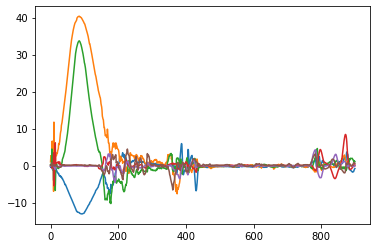

In [351]:
data, label = mealdata[0]
sns.lineplot(x = np.arange(len(data)) ,y=data[:,0])
sns.lineplot(x = np.arange(len(data)) ,y=data[:,1])
sns.lineplot(x = np.arange(len(data)) ,y=data[:,2])
sns.lineplot(x = np.arange(len(data)) ,y=data[:,3])
sns.lineplot(x = np.arange(len(data)) ,y=data[:,4])
sns.lineplot(x = np.arange(len(data)) ,y=data[:,5])

In [352]:
all_dataloader = torch.utils.data.DataLoader(mealdata, batch_size=32, shuffle=False, num_workers=2)

## Use a sampled dataset to test the code and analyze the data

In [353]:
dataset = mealdata.get_dataset(1000,2000)
dataset.head()

100%|██████████| 1000/1000 [00:03<00:00, 317.85it/s]


,data,label
0,"[[tensor(-0.3688), tensor(0.2966), tensor(0.17...",0
1,"[[tensor(-0.2308), tensor(0.5430), tensor(-0.2...",0
2,"[[tensor(-0.2572), tensor(0.0960), tensor(0.05...",0
3,"[[tensor(-0.2820), tensor(0.0201), tensor(-0.0...",0
4,"[[tensor(-0.2318), tensor(0.2656), tensor(-0.4...",0


In [354]:
len(dataset[dataset['label']==1]), len(dataset)

(32, 1000)

## Save data set 

In [355]:
# Save Data set and indices
def save_dataset(data, sample_indices, labels, train_indices, test_indices,file_name=''):
    import json
    
    path_name = './data/'+file_name + '/'
    if not os.path.exists(path_name):
        os.makedirs(path_name)
    
        
    # Save train set indices
    with open(path_name + 'train_indices' +'.json', 'w', newline='') as json_file:
        json.dump({'indices':train_indices.astype(int).tolist()}, json_file)
        json_file.close()
        
    # Save testset indices
    with open(path_name + 'test_indices' +'.json', 'w', newline='') as json_file:
        json.dump({'indices':test_indices.astype(int).tolist()}, json_file)
        json_file.close()

    with open(path_name +  'labels' +'.json', 'w', newline='') as json_file:
        json.dump({'label':labels.astype(int).tolist(), 'sample_indices':sample_indices.astype(int).tolist()}, json_file)
        json_file.close()
        
    # save indices and labels
    with open(path_name +  'data' +'.json', 'w', newline='') as json_file:
        dic = {}
        for i in range(len(data)):
            dic[i] = data[i].astype(float).tolist()
        json.dump(dic, json_file)
        del dic
        json_file.close()
    

    print("Data Saved")
        
            
# save_dataset(mealdata.data,mealdata.data_indices,
#              mealdata.labels_array,
#              train_indices = train_index,
#              test_indices = test_index, file_name='lawler' )

In [356]:
mealdata.data_indices

array([[     0,      0,    900,  46958],
       [     0,    225,   1125,  46958],
       [     0,    450,   1350,  46958],
       ...,
       [    10, 576000, 576900,  37144],
       [    10, 576225, 577125,  37144],
       [    10, 576450, 577350,  37144]])

In [357]:
def load_data(file_name):
    path_name = './data/'
    file = path_name + file_name+'/'
    train_indices , test_indices, labels, sample_indices,data = None,None, None, None, []
    with open( file + 'data'+'.json', 'r') as json_file:
        txt = json_file.read()
        tmp = json.loads(txt)
        for i in range(len(tmp)):
            data.append( np.array(tmp[str(i)]))
        del tmp
    
    
    with open( file + 'train_indices'+'.json', 'r') as json_file:
        txt = json_file.read()
        train_indices = json.loads(txt)
    with open( file + 'test_indices'+'.json', 'r') as json_file:
        txt = json_file.read()
        test_indices = json.loads(txt)
    
    with open( file + 'labels'+'.json', 'r') as json_file:
        txt = json_file.read()
        df = json.loads(txt)
        sample_indices = df['sample_indices']
        labels = df['label']
    print("Data Loaded")
    return data, labels,sample_indices, train_indices , test_indices
    
    
# data, labels,sample_indices, train_indices , test_indices = load_data('lawler')

# 1. Exploratory Data Analysis (EDA)

## 1. 1 Visualize time series dataset

Index: 10 label:  1


Text(0.5, 1.0, 'Gyro Energy ')

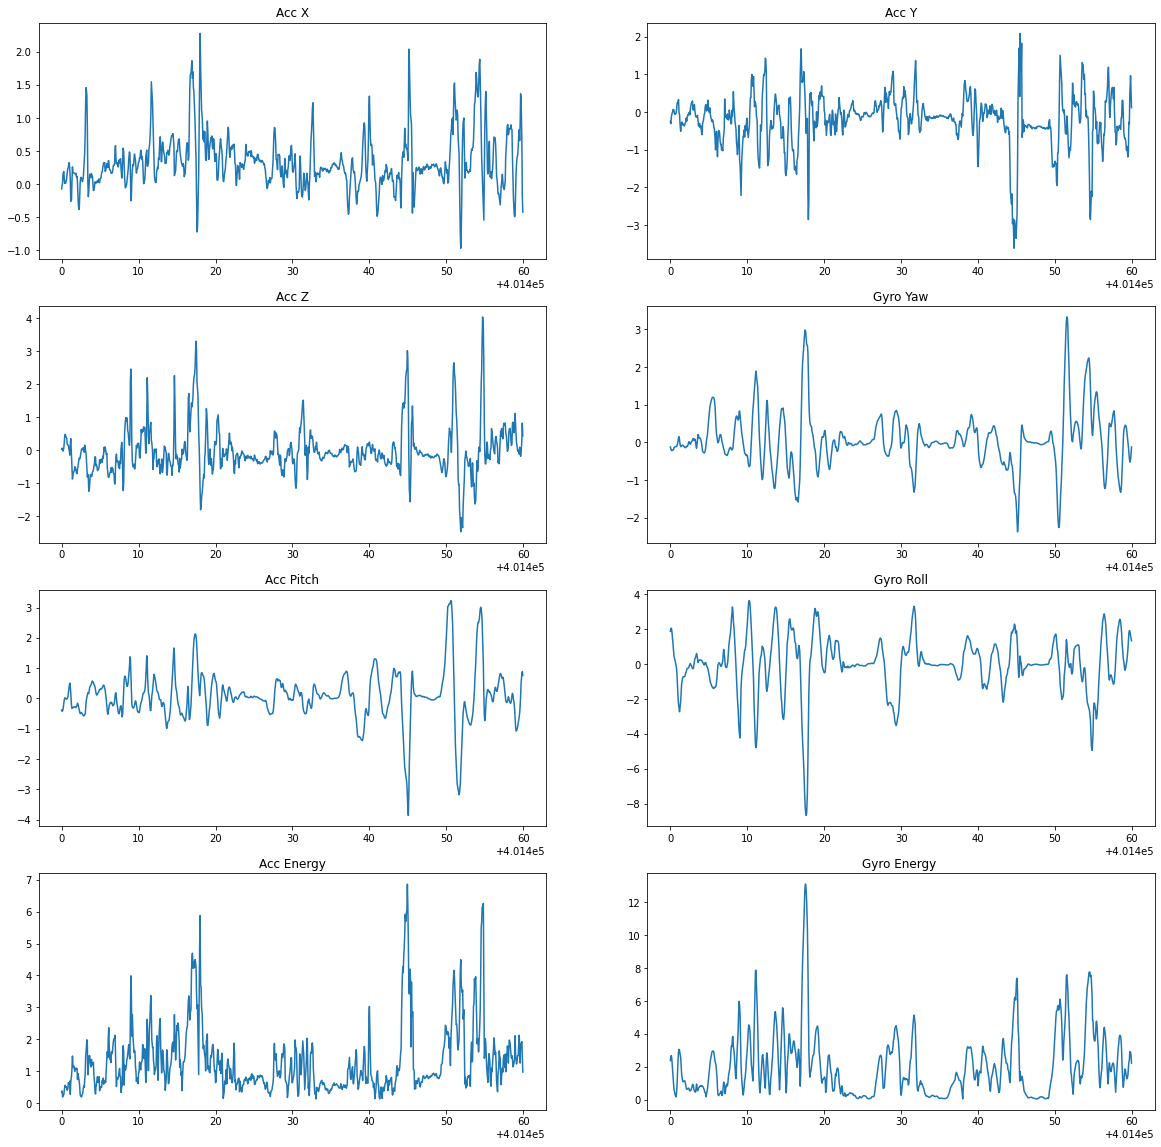

In [358]:
label = 1
data = mealdata.dataset[mealdata.dataset['label'] == label]
n = np.random.randint(0, len(data))

fig, ax = plt.subplots(4, 2,figsize=(20,20))
# data = 
y =  data['data'].iloc[n]
t = data['data'].iloc[n][:,6]

# #normalize acc data across different axis
# sum_acc = torch.sum(torch.abs(y[:,:3]), axis = 1)
# for i in range(3):
#     y[:,i] = y[:,i]/sum_acc

# #normalize gyroscope data across different axis
# sum_gyro = torch.sum(torch.abs(y[:,3:]), axis = 1)
# for i in range(3,6):
#     y[:,i] = y[:, i]/sum_gyro

print("Index:",n,"label: ",label)
ax0 = sns.lineplot(x = t, y= y[:,0],ax= ax[0,0])
ax0.set_title("Acc X")
_ = sns.lineplot(x = t, y= y[:,1],ax= ax[0,1])
ax[0,1].set_title("Acc Y")
_ = sns.lineplot(x = t, y= y[:,2],ax= ax[1,0])
ax[1,0].set_title("Acc Z")

_ = sns.lineplot(x = t, y= y[:,3],ax= ax[1,1])
ax[1,1].set_title("Gyro Yaw")

_ = sns.lineplot(x = t, y= y[:,4],ax= ax[2,0])
ax[2,0].set_title("Acc Pitch")

_ = sns.lineplot(x = t, y= y[:,5],ax= ax[2,1])
ax[2,1].set_title("Gyro Roll")


# Test for wrist energy
acc_sum_0 = (np.abs(y[:,0])+np.abs(y[:,1])+np.abs(y[:,2]))
acc_sum = pd.DataFrame(acc_sum_0.numpy())
acc_sum.rolling(window = 100).mean().fillna(0.0, inplace=True)
acc_sum = acc_sum.to_numpy().squeeze()


gyro_sum_0 = (np.abs(y[:,3])+np.abs(y[:,4])+np.abs(y[:,5]))
gyro_sum = pd.DataFrame(gyro_sum_0.numpy())
gyro_sum.rolling(window = 100).mean().fillna(0.0, inplace=True)
gyro_sum = gyro_sum.to_numpy().squeeze()
# acc_sum = acc_sum.numpy().rolling(window = 150).mean()
# acc_sum.fillna(0.0, inplace =True)


# gyro_sum = pd.DataFrame(gyro_sum.numpy()).rolling(window = 150).mean()
# gyro_sum.fillna(0.0, inplace =True)

_ = sns.lineplot(x = t, y= acc_sum,ax= ax[3,0])
ax[3,0].set_title("Acc Energy")
_ = sns.lineplot(x = t, y= gyro_sum,ax= ax[3,1])

ax[3,1].set_title("Gyro Energy ")

Text(0.5, 1.0, 'Energy Ratio: gyro to acc ')

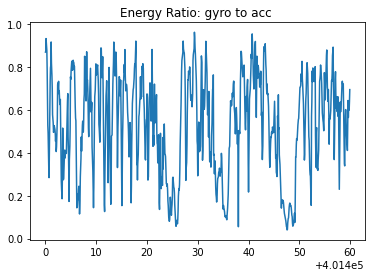

In [359]:

ax1 = sns.lineplot(x = t, y= gyro_sum_0/(acc_sum_0+ gyro_sum_0))
ax1.set_title("Energy Ratio: gyro to acc ")

# ax2 = sns.lineplot(x = t, y= acc_sum_0/gyro_sum_0)
# ax2.set_title("Energy Ratio: acc to gyro")


## Visualize distribution of  accelerator energy and gyroscope(rotation) energy

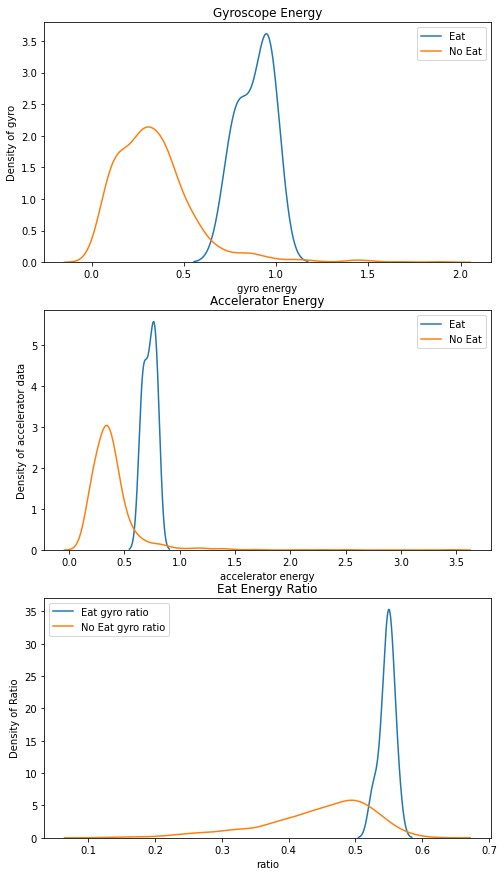

In [360]:
dic= {'0':{'acc':[], 'gyro':[]}, '1':{'acc':[], 'gyro':[]}}
energy_ratio = {'0':[],"1":[]}
# Compute Energy of gyroscope and accelerator
for i in range(len(mealdata.dataset)):
    d, l = mealdata[i]
    
    acc_energy = torch.sum(torch.abs(d[:,:3]).sum(axis=1)).item()/(3*len(d[:]))
    gyro_energy = torch.sum(torch.abs(d[:,3:6]).sum(axis=1)).item()/(3*len(d[:]))
    dic[str(l)]['acc'].append(acc_energy)
    dic[str(l)]['gyro'].append(gyro_energy)
    energy_ratio[str(l)].append([gyro_energy/(acc_energy+ gyro_energy), acc_energy/(acc_energy+ gyro_energy)])

energy_ratio['0']  =np.array(energy_ratio['0'])
energy_ratio['1']  =np.array(energy_ratio['1'])
    
fig, ax = plt.subplots(3,1, figsize=(8,15))
# Visualize distribution of Gyroscope energy
df = pd.DataFrame(dic)
_ = sns.kdeplot(data= df['1'],x=df['1']['gyro'], ax=ax[0])
ax[0].set_title("Gyroscope Energy")
ax[0].set_xlabel("gyro energy")
ax[0].set_ylabel("Density of gyro")
_ = sns.kdeplot(data= df['0'],x=df['0']['gyro'], ax=ax[0])
ax[0].legend(["Eat","No Eat"])

# Visualize distribution of Accelerator energy
_ = sns.kdeplot(data= df['1'],x=df['1']['acc'], ax=ax[1])
ax[1].set_title("Accelerator Energy")
ax[1].set_xlabel("accelerator energy")
ax[1].set_ylabel("Density of accelerator data")
_ = sns.kdeplot(data= df['0'],x=df['0']['acc'], ax=ax[1])
ax[1].legend(["Eat","No Eat"])

_ = sns.kdeplot(data = energy_ratio['1'],x=energy_ratio['1'][:,0], ax=ax[2])
ax[2].set_title("Eat Energy Ratio")
ax[2].set_xlabel("ratio")
ax[2].set_ylabel("Density of Ratio")
_ = sns.kdeplot(x=energy_ratio['0'][:,0], ax=ax[2])
ax[2].legend(["Eat gyro ratio","No Eat gyro ratio"])



## Visualize eating time distribution
Here is a bug in computing time distribution: hours after 13 don't occur

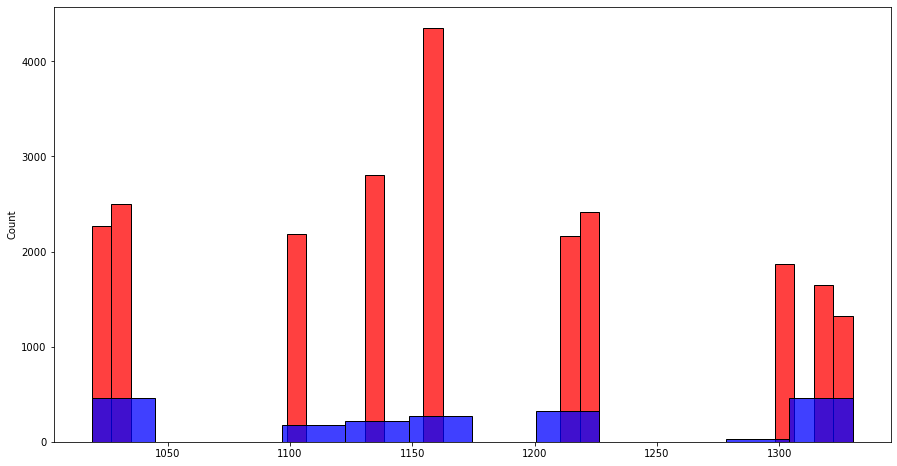

In [361]:
# time_ls = []
# for i in range(len(mealdata.data_indices)):
#     d, l = mealdata[i]
#     offset = mealdata.data_indices[i,3]
#     hour, minutes = offset//(60*60),offset%(60*60)//(60)
#     time_ls.append(hour)
# _ = sns.displot(time_ls)
fig, ax0 = plt.subplots(1,1,figsize = (15,8))
label = 0
time_ls = np.array(mealdata.data_indices)
hour = time_ls[:,3]//(60*60)
minutes = time_ls[:,3]%(60*60)//60


hour_eat = hour[np.array(mealdata.labels_array)==0]
minutes_eat = minutes[np.array(mealdata.labels_array)==0]
time_data = hour_eat*100 + minutes_eat
_ = sns.histplot(x = time_data, ax= ax0,color='r')

label = 0
hour_noteat = hour[ mealdata.labels_array==1]
minutes_noteat = minutes[mealdata.labels_array==1]
time_noteat_data = hour_noteat*100 + minutes_noteat
_ = sns.histplot(x = time_noteat_data, ax=ax0,color='b')


In [335]:
set(minutes)

{2, 5, 16, 19, 20, 21, 28, 30, 36, 56, 58}

In [293]:
# len(hour[(hour==22)]) 
# set(hour)
embedding = nn.Embedding(10, 3)
# a batch of 2 samples of 4 indices each
input = torch.LongTensor([[1,2,4,5],[4,3,2,9]])
embedding(input)

tensor([[[ 0.3676, -0.4364,  0.5717],
         [-0.0851, -0.2849, -0.3385],
         [-0.1856, -1.2960,  0.8346],
         [-1.5188,  1.0632,  0.3435]],

        [[-0.1856, -1.2960,  0.8346],
         [ 0.5529, -0.0905,  2.0362],
         [-0.0851, -0.2849, -0.3385],
         [-0.1706,  0.8074,  1.1506]]], grad_fn=<EmbeddingBackward>)

# 2 Data Preprocessing and Transformation

## 2.1  Split Dataset to trainset and test set

In [183]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split

# Split Training set and testing set here
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)

# Split training set and testing set
train_index, valid_index ,test_index = None, None, None
for train_i, test_i in ss_split.split(np.zeros(mealdata.labels_array.shape) ,mealdata.labels_array):
    train_index = train_i
    test_index = test_i
    print(train_index.shape, test_index.shape)

# Train set    
train_set = torch.utils.data.Subset(mealdata, train_index)

# Test set
test_set = torch.utils.data.Subset(mealdata, test_index)

(32043,) (8011,)


In [184]:
print("Total sample amount: ",len(mealdata.labels_array), "Total training sample amount: ",
      len(train_index),"Total testing sample amount: ", len(test_index))

y_train = mealdata.labels_array[train_index]
y_test = mealdata.labels_array[test_index]

print(" Train sample amount %d, Eat sample: %d  "%(len(train_set),len(y_train[y_train ==1 ]))) 
print("Test sample amount %d, Eat sample: %d "%(len(test_set), len(y_test[y_test ==1 ])))

Total sample amount:  40054 Total training sample amount:  32043 Total testing sample amount:  8011
 Train sample amount 32043, Eat sample: 1271  
Test sample amount 8011, Eat sample: 318 


In [185]:
eat_cnt_train = sum(mealdata.labels_array[train_index])
eat_cnt_test = sum(mealdata.labels_array[test_index])
no_eat_cnt_train = len(train_set)- eat_cnt_train
no_eat_cnt_test = len(test_set) - eat_cnt_test
print("Train-- Eat: %d  Non Eat: %d.   Test--Eat: %d, Non Eat: %d "%(eat_cnt_train, no_eat_cnt_train, eat_cnt_test,no_eat_cnt_test ))
len(mealdata.labels_array)

Train-- Eat: 1271  Non Eat: 30772.   Test--Eat: 318, Non Eat: 7693 


40054

## 2.2 Balance Data Here

In [186]:
def balance_data(dataset, indices, sample_num = 4000):
    """
    Using downsampling to balance data
    """
    eat_labels_index = [i for i in indices if dataset.labels_array[i] == 1]
    not_eat_labels_index = [i for i in indices if dataset.labels_array[i] == 0]
    
    eat_index = np.random.choice(eat_labels_index,sample_num//2).tolist()
    not_eat_index = np.random.choice(not_eat_labels_index,sample_num//2).tolist()
    train_index_balanced = eat_index + not_eat_index
    
    # Train set    
    data_set = torch.utils.data.Subset(dataset, train_index_balanced)
    return data_set, train_index_balanced

train_set_balanced, train_index_balanced = balance_data(mealdata, train_index, sample_num = 4000)
train_loader = torch.utils.data.DataLoader(train_set_balanced,batch_size=32, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set ,batch_size=32, shuffle=True)

print("Balanced Train set size: ",len(train_set_balanced), "\n",
      "train set size before balancing: ",len(train_set), "\n",
      "Test set size: ",len(test_set), "\n",
      "Training Batch amount :",len(train_loader), "\n",
      "Testing Batch amount: ",len(test_loader),"\n")


###############
# Split training set into training set and validation set here if necessary
###############
# train_split_indices , valid_split_indices = None, None
# ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)
# for train_i, valid_i in ss_split.split(np.zeros([len(train_index_balanced),1]) ,mealdata.labels_array[train_index_balanced]):
#     train_split_indices = train_i
#     valid_split_indices = valid_i
    
# # training set after splitting the validation set
# train_splitted_set = torch.utils.data.Subset(train_set_balanced, train_split_indices)
# train_splited_loader = torch.utils.data.DataLoader(train_splitted_set,batch_size=32, shuffle=True)
# # Validation set splitted from training set
# valid_splitted_set = torch.utils.data.Subset(train_set_balanced, valid_split_indices)
# valid_splited_loader = torch.utils.data.DataLoader(valid_splitted_set,batch_size=32, shuffle=True)
# print("Splitted train set size: ", len(train_splitted_set),
#      "Splitted validation set size: ", len(valid_splitted_set))

Balanced Train set size:  4000 
 train set size before balancing:  32043 
 Test set size:  8011 
 Training Batch amount : 125 
 Testing Batch amount:  251 



In [187]:
len(mealdata.labels_array[train_index_balanced][mealdata.labels_array[train_index_balanced]==1])
len(mealdata.labels_array[train_index_balanced][mealdata.labels_array[train_index_balanced]==1])


2000

## 2.3 Split validation set and training set

In [188]:
train_set_balanced[0]

(tensor([[ 5.3993e-02,  3.0351e-02, -3.5271e-01,  ...,  5.8406e-02,
          -9.0755e-01,  1.4175e+05],
         [-1.6492e-01,  1.1930e-01, -1.5165e-01,  ...,  6.0275e-02,
          -1.1083e+00,  1.4175e+05],
         [-1.9272e-01, -3.0968e-02, -8.9809e-02,  ...,  2.0859e-02,
          -1.1184e+00,  1.4175e+05],
         ...,
         [-5.3219e-01, -2.9985e-01,  1.3282e-01,  ...,  9.5297e-02,
          -1.5660e-01,  1.4181e+05],
         [-4.2355e-01, -6.1466e-01, -4.6121e-02,  ...,  7.1508e-02,
          -6.7514e-02,  1.4181e+05],
         [-4.2001e-01, -2.9203e-01, -2.1462e-02,  ...,  8.4848e-02,
           1.4334e-01,  1.4181e+05]]),
 1)

# 3. Model Construction

# Check if cuda is enabled

In [189]:
device = torch.device("cpu")
if torch.cuda.is_available():
    print(torch.cuda.get_device_name())
    device = torch.device("cuda")
print("torch version: ",torch.__version__)
print("Device", device)


Tesla P100-PCIE-12GB
torch version:  1.6.0
Device cuda


# 3.1 Define Discriminator model

#### Discriminator Model 1

In [21]:
from torch import nn
class Discriminator(nn.Module):
    def __init__(self, ngpu, in_channels = 6,n_dims= 16, out_fea = 2):
        super(Discriminator, self).__init__()
        self.in_channels = in_channels
        self.ngpu = ngpu   
        self.conv0 = nn.Conv1d(in_channels, n_dims, kernel_size= 4,  stride= 2, padding=1, bias=False)
        self.conv1 = nn.Conv1d(n_dims, n_dims*8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm1d(n_dims*8)
        self.conv2 = nn.Conv1d(n_dims*8, n_dims*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(n_dims*4)
        self.conv3 = nn.Conv1d(n_dims*4, n_dims*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm1d(n_dims*2)
        self.relu0= nn.LeakyReLU(0.2, inplace=True)
        
        self.avgpool = nn.AdaptiveAvgPool1d(output_size=16)
        self.flatten = nn.Flatten()
#         in_fea = 2048
#         in_fea = 1024
        in_fea = 512
        
        self.linear = nn.Linear(in_features=in_fea, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax()
        self.tanh = nn.Tanh()
        layers = [self.conv0, self.relu0, 
              self.conv1,self.bn1,
              self.conv2,self.bn2,
              self.conv3,self.bn3,
              self.relu0,
              self.avgpool,self.flatten,
              self.linear,    
              self.softmax,
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        
#         input = torch.transpose(input,1,0)
#         print("Changed Input shape: ",input.shape)
        if self.in_channels ==6:
            input = input[:,:6,:]
#         print("Input shape: ",input.shape)
        return self.model(input)


In [22]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [23]:
# testmodel = Discriminator(ngpu=1, out_fea=2).to(device)
# for samples, labels in train_loader:
#     samples = samples.to(device)
#     samples = samples.view(-1,samples.shape[2],samples.shape[1])
#     print(samples.shape)
    
#     preds = testmodel(samples) 
#     preds = preds.squeeze()
#     print(preds.shape)
# #     print(samples.shape,torch.transpose(samples[0],0,1).shape)
# #     print(torch.transpose(samples[0],1,0))
# #     print(samples[0])
#     break


#### Discriminator Model 2

In [190]:
from torch import nn
class Discriminator_v2(nn.Module):
    def __init__(self, ngpu, in_channels = 6,n_dims= 16, out_fea = 2):
        super(Discriminator_v2, self).__init__()
        self.in_channels = in_channels
        self.ngpu = ngpu   
        self.conv0 = nn.Conv1d(in_channels, n_dims, kernel_size= 4,  stride= 2, padding=1, bias=False)
        self.conv1 = nn.Conv1d(n_dims, n_dims*8, 4, 2, 1, bias=False)
        self.bn1 = nn.BatchNorm1d(n_dims*8)
        self.conv2 = nn.Conv1d(n_dims*8, n_dims*4, 4, 2, 1, bias=False)
        self.bn2 = nn.BatchNorm1d(n_dims*4)
        self.conv3 = nn.Conv1d(n_dims*4, n_dims*2, 4, 2, 1, bias=False)
        self.bn3 = nn.BatchNorm1d(n_dims*2)
        
        self.conv4 = nn.Conv1d(n_dims*2, n_dims, 4, 2, 1, bias=False)
        self.bn4 = nn.BatchNorm1d(n_dims)
        
        self.relu0= nn.LeakyReLU(0.2, inplace=True)
        
        self.avgpool = nn.AdaptiveAvgPool1d(output_size=16)
        self.flatten = nn.Flatten()
#         in_fea = 2048
#         in_fea = 1024
#         in_fea = 512
        in_fea = 256
        
        self.linear = nn.Linear(in_features=in_fea, out_features=out_fea, bias=True)
        self.softmax = nn.Softmax()
        self.tanh = nn.Tanh()
        layers = [self.conv0, self.relu0, 
              self.conv1,self.bn1,
              self.conv2,self.bn2,
              self.conv3,self.bn3,
              self.conv4,self.bn4,
              self.relu0,
              self.avgpool,self.flatten,
              self.linear,    
              self.softmax,
        ]
        self.model = nn.Sequential(*layers)

    def forward(self, input):
        
#         input = torch.transpose(input,1,0)
#         print("Changed Input shape: ",input.shape)
        if self.in_channels ==6:
            input = input[:,:6,:]
#         print("Input shape: ",input.shape)
        return self.model(input)


In [191]:
testmodel = Discriminator_v2(ngpu=1, out_fea=2).to(device)
for samples, labels in train_loader:
    samples = samples.to(device)
    samples = samples.view(-1,samples.shape[2],samples.shape[1])
    print(samples.shape)
    
    preds = testmodel(samples) 
    preds = preds.squeeze()
    print(preds.shape)
#     print(samples.shape,torch.transpose(samples[0],0,1).shape)
#     print(torch.transpose(samples[0],1,0))
#     print(samples[0])
    break


torch.Size([32, 7, 900])
torch.Size([32, 2])


/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


# Set parameters and define training functions

In [26]:
def cross_valid(train_model_fn, trainset_index,model, optimizer, criterion, lrscheduler, n_epochs=20,k=5 ):
    
    best_val_score = 0
    overall_best_model = None
    all_loss_ls = []
    all_train_acc_ls = []
    all_valid_acc_ls = []
    
    skf = StratifiedKFold(n_splits=k)
    fold_ind = 0
    
    for (train_index_fold, valid_index_fold) in skf.split(np.zeros(mealdata.labels_array[trainset_index].shape) ,mealdata.labels_array[trainset_index]):
        
        print("Running Fold: %d"%(fold_ind))
        
        # Train set    
        train_set_fold = torch.utils.data.Subset(mealdata, train_index_fold)
        train_loader_fold = torch.utils.data.DataLoader(train_set_fold,batch_size=32, shuffle=True)

        # validation set
        valid_set_fold = torch.utils.data.Subset(mealdata, valid_index_fold)
        valid_loader_fold = torch.utils.data.DataLoader(valid_set_fold,batch_size=32, shuffle=True)
        
        dataloader = (train_loader_fold,valid_loader_fold )
        
        # Re-initialize models
        model =  Discriminator(ngpu=1,in_channels = 7, out_fea=1).to(device)
        model.apply(weights_init)
        model.requires_grad_(True)
        optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
        lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.01,patience=3, threshold = 0.9)
        
        model, best_model,val_score,loss_ls, train_acc_ls, valid_acc_ls = train_model_fn(model,dataloader, optimizer, 
                                                                    criterion, lrscheduler, n_epochs=n_epochs )
        
        if val_score > best_val_score:
            best_val_score = val_score
            overall_best_model = best_model
            torch.save(overall_best_model,"best_model.pt")
            print("Best Model Saved.")
        all_valid_acc_ls.append(valid_acc_ls)
        all_train_acc_ls.append(train_acc_ls)
        all_loss_ls .append(loss_ls )
        fold_ind += 1
        print("Fold %d Completed"%(fold_ind))
        return overall_best_model, best_val_score, all_train_acc_ls,all_loss_ls,all_valid_acc_ls
        

    
    

In [27]:
from tqdm import tqdm
from sklearn.metrics import classification_report,recall_score, precision_score

def eval_model(model,dataloader):
    correct = 0.
    total = 0.
    TP = 0
    FN = 0
    # without update
    with torch.no_grad():
        for samples, labels in dataloader:
            samples = samples.to(device)
            labels = labels.to(device)
            samples = samples.view(-1,samples.shape[2],samples.shape[1])
            outputs = model(samples).to(device).squeeze()
#             preds = preds>=0.5
#             preds = preds.to(dtype = torch.float)
#             preds.requires_grad = True
            _,preds = torch.max(outputs,1)
            for i in range(len(preds)):
                if preds[i] == 1 and labels[i] == 1:
                    TP += 1
                if preds[i] == 0 and labels[i] == 1:
                    FN += 1
            correct += torch.sum((preds == labels)).item()
            total += float(len(labels))
        acc =100 * correct/ total
        recall = TP/(TP+FN)
#         print("Evaluation Acc: %.4f %%,  Recall: %.4f "%(acc , recall))
    return acc, recall
            
            
            
            

def train_model(model,dataloader, optimizer, criterion, lrscheduler, n_epochs=20,
                earlystopping=True, patience= 3, checkpoint_name ="checkpoint.pt" ):
    loss_ls = []
    train_acc_ls = []
    valid_acc_ls = []
    valid_acc = 0.0
    loss =0.0
    train_acc = 0.0
    patience_count = 0
    best_val_score = 0.0
    best_model = None
    
    train_dataloader, valid_dataloader = dataloader
    print("Training set batch amounts:", len(train_dataloader))
    print("Test set :", len(valid_dataloader))
    print("Start Training..")
    
    for e in range(n_epochs):
        running_loss = 0.0
        epoch_loss = 0.0
        running_correct = 0.0
        correct_cnt = 0.0
        total_cnt = 0.0
        TP = 0.
        FN = 0.
        model.train()
        print("Epoch: %d :"%(e))
        for i, (samples, labels) in enumerate(train_dataloader):
            samples = samples.to(device)
            labels = labels.to(device)
            
            optimizer.zero_grad()
            # reshape samples
            samples = samples.view(-1,samples.shape[2],samples.shape[1])
            outputs = model(samples).squeeze()
            _,preds = torch.max(outputs,1)
            
#             print("Preds: ", preds)
#             preds = outputs>=0.5
#             preds = preds.to(dtype = torch.float)
#             preds.requires_grad = True
#             recall = recall_score(labels.cpu().detach(), preds)
            # compute loss 
#             print("Output: ", outputs.shape, "label: ", labels.shape,"preds: ", preds.shape)

            # Compute loss
            loss = criterion(outputs, labels)
            recall = recall_score(labels.cpu().detach(), preds.cpu().detach())

            loss.backward()
            optimizer.step()
            
            loss_ls.append(loss)
            
            # Compute count of TP, FN
            for j in range(len(preds)):
                if preds[j] == 1. and labels[j] == 1.:
                    TP += 1
                if preds[j] == 0. and labels[j] == 1.:
                    FN += 1
            
            running_loss += loss.item()
            correct_cnt += torch.sum((preds == labels)).item()
            total_cnt += float(len(labels))
            batch_acc = 100. * (preds == labels).sum().item()/ float(len(labels))
            if i %50 ==0:
#                 print("===> Batch: %d,  Batch_Loss: %.4f, Train Acc: %.4f %%,  Recall: %.f\n"%(i, loss,batch_acc, recall))
                pass

            
        
        
                    
        # Compute accuracy and loss of one epoch
        epoch_loss = running_loss / len(train_dataloader)  
        epoch_acc = 100* correct_cnt/ total_cnt  # in percentage
        correct_cnt = 0.0
        total_cnt = 0.0
        train_recall = TP/(TP+FN)
        if e %1==0:
            print("Epoch: %d,  Epoch_Loss: %.4f, Train Acc: %.4f %%, Train Recall: %.4f \n"%(e, epoch_loss,
                                                                                     epoch_acc,train_recall))
            print("Training TP: %d ,  FN: %d "%(TP, FN))
        
        
        #Validation mode
        model.eval()
        valid_acc, valid_recall= eval_model(model,valid_dataloader)
        valid_acc_ls.append(valid_acc)   
        print("Validation Acc:  %.4f %%,  Validation Recall: %.4f "%(valid_acc, valid_recall))
        
        # Reset train mode
        model.train()
        lrscheduler.step(valid_acc)
        
        
            
            
        # If earlystopping is enabled, then save model if performance is improved
        if earlystopping:
            if valid_acc > best_val_score or best_val_score == 0.0:
                best_val_score = valid_acc
                torch.save(model,checkpoint_name)
                patience_count = 0
                print("Checkpoint Saved")
            else:
                if patience_count < patience:
                    patience_count += 1
                else:
                    break
        print("\n")
        
        
            
    # Load best model
    best_model = torch.load("checkpoint.pt")
    print("Load Best Model.")
    print("Training completed")
        
    return model, best_model,best_val_score,loss_ls, train_acc_ls, valid_acc_ls
            
            
    

In [28]:
# loss = nn.CrossEntropyLoss()
# input = torch.randn(3, 5, requires_grad=True)
# target = torch.empty(3, dtype=torch.long).random_(5)
# output = loss(input, target)
# # output.backward()
# input, target, output

#### Train a single model and check if model converges

In [190]:
model =  Discriminator(ngpu=1,in_channels = 6, out_fea=2).to(device)
model.apply(weights_init)
model.requires_grad_(True)
criterion = nn.CrossEntropyLoss()
# optimizer = optim.SGD(model.parameters(),lr=0.01, momentum=0.9)
optimizer = optim.Adam(model.parameters(),lr=0.01)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.01,patience=4, threshold = 0.9)
dataloader = (train_loader, test_loader)
model, best_model,val_score,loss_ls, train_acc_ls, valid_acc_ls = train_model(model,dataloader, optimizer, 
                                                                    criterion, lrscheduler, n_epochs=50, patience = 10 )

Training set batch amounts: 125
Test set : 158
Start Training..
Epoch: 0 :
Epoch: 0,  Epoch_Loss: 0.6736, Train Acc: 61.8250 %, Train Recall: 0.5710 

Training TP: 1142 ,  FN: 858 
Validation Acc:  79.2401 %,  Validation Recall: 0.4469 
Checkpoint Saved


Epoch: 1 :
Epoch: 1,  Epoch_Loss: 0.6632, Train Acc: 64.1000 %, Train Recall: 0.5225 

Training TP: 1045 ,  FN: 955 
Validation Acc:  74.2727 %,  Validation Recall: 0.4914 


Epoch: 2 :
Epoch: 2,  Epoch_Loss: 0.6642, Train Acc: 64.2000 %, Train Recall: 0.5100 

Training TP: 1020 ,  FN: 980 
Validation Acc:  74.1935 %,  Validation Recall: 0.4914 


Epoch: 3 :
Epoch: 3,  Epoch_Loss: 0.6609, Train Acc: 64.6000 %, Train Recall: 0.5150 

Training TP: 1030 ,  FN: 970 
Validation Acc:  77.4985 %,  Validation Recall: 0.4716 


Epoch: 4 :
Epoch: 4,  Epoch_Loss: 0.6629, Train Acc: 64.5000 %, Train Recall: 0.4975 

Training TP: 995 ,  FN: 1005 
Validation Acc:  76.4298 %,  Validation Recall: 0.4889 


Epoch: 5 :
Epoch: 5,  Epoch_Loss: 0.6631, Tr

In [191]:
# overall_best_model = torch.load("best_model.pt")
# overall_best_model.eval()
best_model = torch.load("checkpoint.pt")
best_model.eval()
test_acc= eval_model(best_model,test_loader)
test_acc

(79.24005541262616, 0.4469135802469136)

## Try using time feature column

In [214]:
model_t =  Discriminator_v2(ngpu=1,in_channels = 6, out_fea=2).to(device)
model_t.apply(weights_init)
model_t.requires_grad_(True)
criterion = nn.CrossEntropyLoss()
# criterion = nn.BCELoss()
optimizer_t = optim.SGD(model_t.parameters(),lr=0.01, momentum=0.9)
# optimizer_t = optim.Adam(model_t.parameters(),lr=0.01)
lrscheduler_t = optim.lr_scheduler.ReduceLROnPlateau(optimizer_t, mode='max', factor=0.01,patience=4, threshold = 0.9)
dataloader = (train_loader, test_loader)
model_t, best_model_t,val_score,loss_ls, train_acc_ls, valid_acc_ls = train_model(model_t,dataloader, optimizer_t, 
                                                                    criterion, lrscheduler_t, n_epochs=50, patience = 20,
                                                                                 checkpoint_name="time_fea_checkpoint.pt")

Training set batch amounts: 125
Test set : 158
Start Training..
Epoch: 0 :


KeyboardInterrupt: 

In [209]:
best_model_t = torch.load("time_fea_checkpoint.pt")
best_model_t.eval()
test_acc= eval_model(best_model_t,test_loader)
test_acc

(76.9245992479715, 0.47160493827160493)

## Test for other data set

In [29]:
mealdata_2 = MealsDataset(names=['lawler'],ratio_dataset=1,winmin=10,load_splitted_dataset= False, gtperc = 0.9)

Loading Dataset ...
Loading File:  ../Data/IndividualData/lawler-data/11.14/11.14.shm
Loading File:  ../Data/IndividualData/lawler-data/10.14/10.14.shm
Loading File:  ../Data/IndividualData/lawler-data/10.26/10.26.shm
Loading File:  ../Data/IndividualData/lawler-data/10.21/10.21.shm
Loading File:  ../Data/IndividualData/lawler-data/10.19/10.19.shm
Loading File:  ../Data/IndividualData/lawler-data/11.3/11.3.shm
Loading File:  ../Data/IndividualData/lawler-data/10.4/10.4.shm
Loading File:  ../Data/IndividualData/lawler-data/9.23/9.23_13hr.shm
Loading File:  ../Data/IndividualData/lawler-data/10.28/10.28.shm
Loading File:  ../Data/IndividualData/lawler-data/10.10/10.10.shm
Loading File:  ../Data/IndividualData/lawler-data/11.4/11.4.shm
Loading File:  ../Data/IndividualData/lawler-data/10.31/10.31.shm
Loading File:  ../Data/IndividualData/lawler-data/10.31/evening-2hr_goodDinnerTemplate_CFAmeal/10.31.shm
Loading File:  ../Data/IndividualData/lawler-data/10.20/afternoon_2hr33min/10.20.shm
L

In [30]:

dataset_2 = mealdata_2.get_dataset(0,1000)
dataset_2.head()['data'].iloc[0].shape

100%|██████████| 1000/1000 [00:04<00:00, 220.36it/s]


torch.Size([9000, 7])

In [31]:
from sklearn.model_selection import StratifiedShuffleSplit, StratifiedKFold, train_test_split

# Split Training set and testing set here
ss_split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=2021)

# Split training set and testing set
train_index_2, valid_index_2 ,test_index_2 = None, None, None
for train_i, test_i in ss_split.split(np.zeros(mealdata_2.labels_array.shape) ,mealdata_2.labels_array):
    train_index_2 = train_i
    test_index_2 = test_i
    print(train_index_2.shape, test_index_2.shape)

# Train set    
train_set_2 = torch.utils.data.Subset(mealdata_2, train_index_2)

# Test set
test_set_2 = torch.utils.data.Subset(mealdata_2, test_index_2)


print("Total sample amount: ",len(mealdata_2.labels_array), "Total training sample amount: ",
      len(train_index_2),"Total testing sample amount: ", len(test_index_2))

y_train_2 = mealdata_2.labels_array[train_index_2]
y_test_2 = mealdata_2.labels_array[test_index_2]

print(" Train sample amount %d, Eat sample: %d  "%(len(train_set_2),len(y_train_2[y_train_2 ==1 ]))) 
print("Test sample amount %d, Eat sample: %d "%(len(test_set_2), len(y_test[y_test ==1 ])))

(31380,) (7846,)
Total sample amount:  39226 Total training sample amount:  31380 Total testing sample amount:  7846
 Train sample amount 31380, Eat sample: 417  
Test sample amount 7846, Eat sample: 405 


In [32]:
train_set_balanced_2, train_index_balanced_2 = balance_data(mealdata_2, train_index_2, sample_num = 4000)
train_loader_2 = torch.utils.data.DataLoader(train_set_balanced_2,batch_size=32, shuffle=True)
test_loader_2 = torch.utils.data.DataLoader(test_set_2 ,batch_size=32, shuffle=True)

print("Balanced Train set size: ",len(train_set_balanced_2), "\n",
      "train set size before balancing: ",len(train_set_2), "\n",
      "Test set size: ",len(test_set_2), "\n",
      "Training Batch amount :",len(train_loader_2), "\n",
      "Testing Batch amount: ",len(test_loader_2),"\n")



Balanced Train set size:  4000 
 train set size before balancing:  31380 
 Test set size:  7846 
 Training Batch amount : 125 
 Testing Batch amount:  246 



In [ ]:
from torch import optim

model_2 =  Discriminator_v2(ngpu=1,in_channels = 6, out_fea=2).to(device)
# model_2.apply(weights_init)
model_2.requires_grad_(True)
criterion_2 = nn.CrossEntropyLoss()
optimizer_2 = optim.SGD(model_2.parameters(),lr=0.01, momentum=0.9)
# optimizer_t = optim.Adam(model_t.parameters(),lr=0.01)
lrscheduler_2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer_2, mode='max', factor=0.01,patience=4, threshold = 0.9)
dataloader_2 = (train_loader_2, test_loader_2)
model_2, best_model_2,val_score_2,loss_ls_2, train_acc_ls_2, valid_acc_ls_2 = train_model(model_2,dataloader_2, optimizer_2, 
                                                                    criterion_2, lrscheduler_2, n_epochs=50, earlystopping=False,
                                                                                          patience = 20,
                                                                                 checkpoint_name="time_fea_checkpoint_p2.pt")

Training set batch amounts: 125
Test set : 246
Start Training..
Epoch: 0 :


/home/wenkanw/.conda/envs/mlenv/lib/python3.8/site-packages/torch/nn/modules/container.py:117: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


Epoch: 0,  Epoch_Loss: 0.6555, Train Acc: 60.2750 %, Train Recall: 0.6850 

Training TP: 1370 ,  FN: 630 
Validation Acc:  53.0971 %,  Validation Recall: 0.9712 


Epoch: 1 :
Epoch: 1,  Epoch_Loss: 0.6111, Train Acc: 67.7250 %, Train Recall: 0.7990 

Training TP: 1598 ,  FN: 402 
Validation Acc:  47.3745 %,  Validation Recall: 0.9808 


Epoch: 2 :
Epoch: 2,  Epoch_Loss: 0.6022, Train Acc: 67.7500 %, Train Recall: 0.8080 

Training TP: 1616 ,  FN: 384 
Validation Acc:  49.2990 %,  Validation Recall: 0.9808 


Epoch: 3 :
Epoch: 3,  Epoch_Loss: 0.6000, Train Acc: 68.3750 %, Train Recall: 0.8420 

Training TP: 1684 ,  FN: 316 
Validation Acc:  56.7295 %,  Validation Recall: 0.9808 


Epoch: 4 :
Epoch: 4,  Epoch_Loss: 0.5949, Train Acc: 68.6000 %, Train Recall: 0.8210 

Training TP: 1642 ,  FN: 358 
Validation Acc:  46.0744 %,  Validation Recall: 0.9808 


Epoch: 5 :
Epoch: 5,  Epoch_Loss: 0.5900, Train Acc: 70.0250 %, Train Recall: 0.8770 

Training TP: 1754 ,  FN: 246 
Validation Acc:  39

# 4. Model Evaulation and Improvement using Cross-validation

In [59]:
from torch import optim
# device  = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = Discriminator(ngpu=1,in_channels = 7, out_fea=1).to(device)
model.apply(weights_init)
_ = model.requires_grad_(True)
dataloader = (train_loader, test_loader)
criterion = nn.BCELoss()
optimizer = optim.SGD(model.parameters(),lr=0.001, momentum=0.9)
lrscheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.01,patience=3, threshold = 0.9)

In [324]:
# model, best_model,best_val_score,loss_ls, train_acc_ls, valid_acc_ls= train_model(model,dataloader, optimizer, 
#                                                          criterion, lrscheduler, n_epochs=20 )


overall_best_model, best_val_score, all_train_acc_ls,all_loss_ls,all_valid_acc_ls = cross_valid(train_model,train_index_balanced, model,
                                                                                                optimizer, criterion, 
                                                                                                lrscheduler, n_epochs=1,k=2)

Running Fold: 0
Training set size: 313
Test set size: 313
Start Training..
Epoch: 0, Batch: 0,  Batch_Loss: 9.3750, Train Acc: 90.6250 % 

Epoch: 0, Batch: 100,  Batch_Loss: 6.2500, Train Acc: 93.7500 % 

Epoch: 0, Batch: 200,  Batch_Loss: 9.3750, Train Acc: 90.6250 % 

Epoch: 0, Batch: 300,  Batch_Loss: 0.0000, Train Acc: 100.0000 % 

Checkpoint Saved
Epoch: 0,  Epoch_Loss: 6.2001, Train Acc: 93.8000 %,  Validation Acc: 97.6100 % 

Load Best Model.
Training completed
Best Model Saved.
Fold 1 Completed


In [286]:
len(train_loader)

867

In [275]:
# !du -h best_model.pt
# overall_best_model = torch.load("checkpoint.pt")
# overall_best_model.named_parameters()
# model.named_parameters

In [325]:
# overall_best_model = torch.load("best_model.pt")
# overall_best_model.eval()
best_model = torch.load("checkpoint.pt")
best_model.eval()
test_acc= eval_model(best_model,test_loader)
test_acc

95.59727249768498

In [328]:
eat_test = [i for i in train_index_balanced if mealdata.labels_array[i]==1]
eat_test_set = torch.utils.data.Subset(mealdata, eat_test)
eat_loader = torch.utils.data.DataLoader(eat_test_set,batch_size=32, shuffle=True)
test_acc= eval_model(best_model,eat_loader)
test_acc

0.0

# Debugging and Testing codes below

In [264]:
len(train_loader)

867

In [140]:
m = nn.Conv1d(16, 33, 3, stride=2)
input = torch.randn(20, 16, 50)
output = m(input)
output.shape,input.shape

(torch.Size([20, 33, 24]), torch.Size([20, 16, 50]))

In [280]:
x= torch.tensor([1,0,1,0,1])
y= torch.tensor([0,1,1,0,1])

correct = torch.sum((x == y))/float(len(x))
correct

tensor(0.6000)

In [297]:
for samples, labels in train_loader:
    print(samples.requires_grad)
    break

False
